<h1 style="font-size:32px;">Analiza zadovoljstva putnika u zračnom prometu</h1>

Zračni promet je jedan od ključnih oblika suvremenog prijevoza, a kvaliteta usluge i zadovoljstvo putnika postaju sve važniji čimbenici konkurentnosti zrakoplovnih kompanija. Razumijevanje čimbenika koji utječu na zadovoljstvo putnika ključno je za unapređenje poslovnih procesa, poboljšanje korisničkog iskustva i donošenje strateških odluka.

Zadovoljstvo putnika u zračnom prometu ovisi o nizu različitih faktora, uključujući demografske karakteristike putnika, vrstu putovanja, razinu udobnosti, točnost letova, kašnjenja te opće iskustvo korištenja usluge. Analiza takvih podataka omogućuje zrakoplovnim kompanijama da uoče obrasce ponašanja putnika, prepoznaju potencijalne probleme u pružanju usluge te razviju mjere za povećanje razine zadovoljstva.

U projektu se provodi analiza podataka o putnicima prikupljenih sa kaggle.com i generiranih sa generatedata.com, važna je sama priprema, čišćenje i integracija podataka za daljnju analizu. Obrada podataka iz CSV i JSON datoteka, koji se nakon čišćenja i spajanja koriste za istraživanje odnosa između karakteristika putnika, uvjeta putovanja i razine zadovoljstva. Cilj rada je da kombiniranjem podatke zadovoljstva putnika s razinom stresa i brojem članova obitelji koji putuju sa putnikom, da dam uvid u moguću povezanost između zadovoljstva putnika te stresa s obzirom na broj članova obitelji koji putuju sa putnikom, koji doprinose boljem razumijevanju zadovoljstva putnika u zračnom prometu.

<h1 style="font-size:32px;">Motivacija</h1>

Ovu temu sam odabrao jer me zanima putovanje avionom. Oduvijek sam htio putovati avionom negdje ali još nikad nisam imao mogučnost to napraviti, a ovako mogu vidjeti podatke koji tip leta ljudi najčešće uzimaju, koliko daleko lete, kakvo je zadovoljstvo sa letom. Time se zapravo informiram za svoja buduća putovanja avionom. 

In [1]:
!pip install flask sqlalchemy

<h1 style="font-size:32px;">Izvor i prikupljanje podataka</h1>

U ovom projektu korištena su dva skupa podataka:

Skup podataka 1 – zadovoljstvo putnika u CSV formatu

Podaci preuzeti sa kaggle platforme 
TJ Klein, Airline passenger satisfaction, [DATASET]. Kaggle. Preuzeto 19.siječnja 2025. sa https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

Prvi skup podataka preuzet je kao gotov skup podataka u CSV formatu te sadrži informacije o putnicima i njihovom zadovoljstvu uslugama u prometu. Skup uključuje podatke kao što su ocjena zadovoljstva, klasa putovanja, kašnjenje, vrsta usluge i slični atributi relevantni za analizu korisničkog iskustva.
Podaci su učitani iz CSV datoteke pomoću biblioteke pandas. 

Skup podataka 2 – stres i broj članova obitelji koji putuju sa putnikom u JSON formatu

Podaci dobiveni preko generatora podataka
Podaci generirani 19.siječnja 2025 na https://generatedata.com/

Drugi skup podataka generiran je pomoću alata generatedata.com te je pohranjen u JSON formatu. Ovaj skup sadrži dodatne informacije o putnicima, uključujući razinu stresa tijekom putovanja te broj članova obitelji koji putuju s putnikom. Ovaj skup podataka koristi se za proširenje postojeće analize zadovoljstva putnika dodavanjem psiholoških i socijalnih čimbenika.  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import os
import logging
import matplotlib.image as mpimg


#učitavanje podataka iz csv datoteke 
csv_lokacija = "Airline_Passenger_Satisfaction.csv"
df_csv = pd.read_csv(csv_lokacija)

#učitavanje podataka iz json datoteke 
json_lokacija = "Airline_Passenger_Satisfaction - generated.json"
df_json = pd.read_json(json_lokacija)


<h1 style="font-size:32px;">Pretprocesiranje podataka</h1>

Prije same analize bilo je potrebno provesti pretprocesiranje podataka kako bi se osigurala njihova kvaliteta i kompatibilnost za integraciju.
Prvo sam išao provjeriti i prilagoditi tipove podataka te provjeriti pojavljuju li se duplikati kod identifikatora putnika

Passenger_id će se koristi za povezivanje dvaju skupova podataka. Kod csv datoteke je atribut bio nazvan id, a kod json datoteke je bio nazvan passenger_id pa sam id u csv-u preimenovao u passenger_id kako bi preko toga mogao spojiti svoje dvije datoteke.

In [3]:
df_csv.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [4]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [5]:
print("\nNaN vrijednosti u CSV-u:")
print(df_csv.isna().sum())


NaN vrijednosti u CSV-u:
Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction  

In [6]:
print("Broj duplikata u CSV:", df_csv.duplicated().sum())

Broj duplikata u CSV: 0


In [7]:
df_json.head()

,passenger_id,stress_level,family_members
0,91314,1,2
1,36901,1,4
2,52413,3,4
3,82667,3,4
4,19847,1,4


In [8]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   passenger_id    1000 non-null   int64
 1   stress_level    1000 non-null   int64
 2   family_members  1000 non-null   int64
dtypes: int64(3)
memory usage: 23.6 KB


In [9]:
print("\nNaN vrijednosti u JSON-u:")
print(df_json.isna().sum())


NaN vrijednosti u JSON-u:
passenger_id      0
stress_level      0
family_members    0
dtype: int64


In [10]:
print("Broj duplikata u JSON:", df_json.duplicated().sum())

Broj duplikata u JSON: 0


In [11]:
#preimenovanje stupca id u csv datoteci u passenger_id preko kojega će se kasnije spojiti podaci iz datoteka
df_csv.rename(columns={"id": "passenger_id"}, inplace=True)

<h1 style="font-size:32px;">Čišćenje podataka</h1>

In [12]:
#uklanjanjamo duplikata
df_csv = df_csv.drop_duplicates()
df_json = df_json.drop_duplicates()

#zadržavamo samo ove stupce u csv-u
df_csv = df_csv[[
    "passenger_id",
    "Gender",
    "Customer Type",
    "Age",
    "Type of Travel",
    "Flight Distance",
    "Class",
    "Departure Delay in Minutes",
    "satisfaction"
]]

#zadržavamo samo ove stupce u json-u
df_json = df_json[[
    "passenger_id",
    "stress_level",
    "family_members"
]]

#prikaz csv-a i json-a nakon čišćenja
print("\nCSV nakon čišćenja:")
print(df_csv.head())

print("\nJSON nakon čišćenja:")
print(df_json.head())


CSV nakon čišćenja:
   passenger_id  Gender      Customer Type  Age   Type of Travel  \
0         19556  Female     Loyal Customer   52  Business travel   
1         90035  Female     Loyal Customer   36  Business travel   
2         12360    Male  disloyal Customer   20  Business travel   
3         77959    Male     Loyal Customer   44  Business travel   
4         36875  Female     Loyal Customer   49  Business travel   

   Flight Distance     Class  Departure Delay in Minutes  \
0              160       Eco                          50   
1             2863  Business                           0   
2              192       Eco                           0   
3             3377  Business                           0   
4             1182       Eco                           0   

              satisfaction  
0                satisfied  
1                satisfied  
2  neutral or dissatisfied  
3                satisfied  
4                satisfied  

JSON nakon čišćenja:
   passenger_

Najprije su iz oba skupa podataka uklonjeni duplikati zapisa kako bi se spriječilo višestruko pojavljivanje istih vrijednosti u analizi. Time se izbjegava dvostruko brojanje i netočni rezultati analize.

Nakon toga je izvršena selekcija atributa. Iz CSV datoteke zadržani su samo stupci koji opisuju osnovne karakteristike putnika i putovanja, uključujući identifikator putnika, demografske podatke, tip putovanja, udaljenost leta, klasu putovanja, kašnjenje polaska i razinu zadovoljstva. Svi ostali stupci uklonjeni su kako bi se pojednostavio rad s podacima te se tako optimizirala memorijska potrošnja. 

Iz JSON datoteke zadržani su isključivo dodatni atributi vezani uz putnika, odnosno razina stresa i broj članova obitelji na putovanju, zajedno s identifikatorom putnika.

Također ti stupci su ostavljeni jer će se kasnije koristiti u grafičkoj analizi pomoću grafikona.

<h1 style="font-size:32px;">Spajanje csv i json datoteke - integracija podataka</h1>

Nakon pretprocesiranja i čišćenja provedeno je povezivanje csv i json datoteke, spajanje podataka iz oba skupa u jedinstveni skup podataka. Spajanje je ostvareno spajanjem skupova pomoću zajedničkog atributa passenger_id. Na ovaj način stvorili smo novu datoteku koja sadrži id putnika, spol, tip kupca, dob, vrsta putovanja, duljina puta, klasa, kašnjenje polijetanja aviona u minutama, zadovoljstvo, razina stresa i broj članova obitelji s kojima putuju.

Ovaj novi skup podataka omogućuje jednostavniju i bolju analizu faktora koji utječu na zadovoljstvo putnika u prometu, pošto filtriramo samo one stupce preko kojih će nam biti bolje napraviti analizu.

In [13]:
df_finalno = pd.merge(df_csv, df_json, on="passenger_id", how="inner")

#prikaz novog skupa podataka
print("\nIntegrirani skup podataka:")
print(df_finalno.head())


Integrirani skup podataka:
   passenger_id  Gender   Customer Type  Age   Type of Travel  \
0         53605  Female  Loyal Customer   25  Business travel   
1         80531    Male  Loyal Customer   43  Business travel   
2         74151  Female  Loyal Customer   36  Business travel   
3         40114    Male  Loyal Customer   24  Business travel   
4         92898  Female  Loyal Customer   42  Business travel   

   Flight Distance     Class  Departure Delay in Minutes  \
0             1874       Eco                          86   
1             1678  Business                           0   
2             2046  Business                           0   
3              368       Eco                           5   
4              134  Business                           0   

              satisfaction  stress_level  family_members  
0                satisfied             1               2  
1                satisfied             2               1  
2  neutral or dissatisfied             3   

In [14]:
df_finalno.head()

,passenger_id,Gender,Customer Type,Age,Type of Travel,Flight Distance,Class,Departure Delay in Minutes,satisfaction,stress_level,family_members
0,53605,Female,Loyal Customer,25,Business travel,1874,Eco,86,satisfied,1,2
1,80531,Male,Loyal Customer,43,Business travel,1678,Business,0,satisfied,2,1
2,74151,Female,Loyal Customer,36,Business travel,2046,Business,0,neutral or dissatisfied,3,2
3,40114,Male,Loyal Customer,24,Business travel,368,Eco,5,satisfied,4,5
4,92898,Female,Loyal Customer,42,Business travel,134,Business,0,satisfied,3,4


Skupovi podataka iz json-a i csv-a se spajaju preko zajedničkog atributa passenger_id 

<h1 style="font-size:32px;">Uklanjanje duplikata</h1>

In [15]:
print(f"Broj redova prije uklanjanja duplikata: {len(df_finalno)}")

df_finalno = df_finalno.drop_duplicates()

print(f"Broj redova nakon uklanjanja duplikata: {len(df_finalno)}")

Broj redova prije uklanjanja duplikata: 194
Broj redova nakon uklanjanja duplikata: 194


Za svaki slučaj provedeno je čišćenje duplikata u integriranom skupu podataka, ali njih na kraju nije bilo.

<h1 style="font-size:32px;">Pohrana podataka u bazu</h1>

Nakon što sam očistio i spojio obje datoteke, išao sam te podatke pohraniti u bazu podataka kako bi ih kasnije mogao analizirati i koristiti. Baza podataka u kojoj će podaci biti pohranjeni zove se putnici_baza.db, a ona se nalazi u direktoriju gdje je ova jupyter notebook datoteka pohranjena sa svim ostalim materijalima.
Kod za povezivanje na SQLite bazu koristi create_engine funkciju iz biblioteke sqalchemy, koja služi za stvaranje ili povezivanje na SQLite bazu podataka.

Tu u primjeru, veza na bazu je napravljena preko sqlite:///putnici_baza.db, i to znači da će se baza nalaziti u trenutnom direktoriju u kojem se izvode sve ostale funkcije. Dalje se izvršava SQL upit koji dohvaća sve podatke iz tablice putnici. Sada kada imamo kreiranu bazu podataka dalje nam ostaje izrada REST API-a i vizualizacija samih podataka.

In [16]:
#kreiranje ili povezivanje na SQLite bazu podataka
DATABASE_PATH = os.path.join(os.getcwd(), "putnici_baza.db")
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

print("Baza:", DATABASE_PATH)
def fetch_data():
    return df_finalno

#kreiramo tablicu
def create_table_if_not_exists():
    try:
        with engine.connect() as connection:
            query = """
                CREATE TABLE IF NOT EXISTS putnici (
                    passenger_id INTEGER,
                    Gender TEXT,
                    Customer_Type TEXT,
                    Age INTEGER,
                    Type_of_Travel TEXT,
                    Flight_Distance FLOAT,
                    Class TEXT,
                    Departure_Delay_in_Minutes FLOAT,
                    satisfaction TEXT,
                    stress_level FLOAT,
                    family_members FLOAT
                );
            """
            connection.execute(text(query))
            print("Tablica 'putnici' je uspješno stvorena ili već postoji.")
    except Exception as e:
        print(f"Greška pri kreiranju tablice: {str(e)}")

#postavljamo podatke unutar tablice
def insert_data_into_table(df):
    try:
        with engine.connect() as connection:
            df.to_sql('putnici', con=connection, if_exists='replace', index=False)
            print("Podaci su uspješno uneseni u tablicu 'putnici'.")
    except Exception as e:
        print(f"Greška pri unosu podataka: {str(e)}")

create_table_if_not_exists()

merged_data = fetch_data()

insert_data_into_table(merged_data)

with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM putnici LIMIT 8"))
    for row in result:
        print(row)      #ispisujemo podatke iz tablice


Baza: C:\Users\Ivan\putnici_baza.db
Tablica 'putnici' je uspješno stvorena ili već postoji.
Podaci su uspješno uneseni u tablicu 'putnici'.
(53605, 'Female', 'Loyal Customer', 25, 'Business travel', 1874, 'Eco', 86, 'satisfied', 1, 2)
(80531, 'Male', 'Loyal Customer', 43, 'Business travel', 1678, 'Business', 0, 'satisfied', 2, 1)
(74151, 'Female', 'Loyal Customer', 36, 'Business travel', 2046, 'Business', 0, 'neutral or dissatisfied', 3, 2)
(40114, 'Male', 'Loyal Customer', 24, 'Business travel', 368, 'Eco', 5, 'satisfied', 4, 5)
(92898, 'Female', 'Loyal Customer', 42, 'Business travel', 134, 'Business', 0, 'satisfied', 3, 4)
(40956, 'Female', 'disloyal Customer', 41, 'Business travel', 601, 'Eco', 1, 'neutral or dissatisfied', 3, 1)
(88471, 'Male', 'Loyal Customer', 39, 'Business travel', 2275, 'Business', 0, 'satisfied', 3, 5)
(82667, 'Female', 'Loyal Customer', 14, 'Personal Travel', 120, 'Eco', 0, 'neutral or dissatisfied', 3, 4)


Prikaz stupaca iz tablice putnik

In [17]:
print(df_finalno.columns)

Index(['passenger_id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Flight Distance', 'Class', 'Departure Delay in Minutes',
       'satisfaction', 'stress_level', 'family_members'],
      dtype='object')


<h1 style="font-size:32px;">Kreiranje i prikaz rada aplikacije te vizualizacija podataka</h1>

U ovome dijelu kreiramo Flask aplikaciju preko koje je omogućena interakcija s bazom podataka putem REST API-ja. Aplikacija se povezuje na SQLite bazu podataka putnici_baza.db koja je locirana u trenutnom direktoriju gdje se izvršavaju ostale funkcije, koristi se SQLAlchemy za komunikaciju s bazom. 

Sama Flask aplikacija ima nekoliko endpointa: prvi, root endpoint, koji samo ispisuje poruku dobrodošlice, to nam omogućuje da provjerimo da aplikacija ispravno radi. Drugi endpoint nam omogućuje dohvaćanje svih podataka iz tablice putnik, a treći endpoint omogućuje dohvaćanje specifičnog putnika na temelju njegovog ID-a. Za svaku ovu funkcionalnost se koristi SQLAlchemy koji omogućuje izvođenje upita na bazi podataka, a rezultati su pretvoreni u riječnike za lakše korištenje u API odgovoru.

Nakon što pokrenemo API, podatci se dohvaćaju iz baze podataka i onda obrađuju u Pythonu. U kodu se koristi pandas koji omogućuje manipulaciju podataka, a onda se prikazuje nekoliko vizualizacija pomoću Plotly knjižnice.

Ovim kodom nam je omogućena analiza zadovoljstva putnika u zračnom prometu, kako vrsta klase u zrakoplovu, tip korisnika te razina stresa utječu na zadovoljstvo putnika u zračnom prometu. Prikazani su grafovi koji olakšavaju vizualizaciju tih podataka.

In [18]:
from flask import Flask, jsonify, request
from sqlalchemy import create_engine, text
from threading import Thread

#kreiranje Flask instance
app = Flask(__name__)

#povezivanje s bazom podataka
DATABASE_PATH = os.path.join(os.getcwd(), "putnici_baza.db")
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

#dohvaćanje podatka iz tablice putnici
def fetch_data():
    with engine.connect() as connection:
        df = pd.read_sql("SELECT * FROM putnici", connection)
    return df

#poruka u root-u
@app.route("/", methods=["GET"])
def root():
    return jsonify({"message": "Dobrodošli u Zadovoljstvo putnika u zračnom prometu REST API."})

#dohvaćanje svih putnika
@app.route("/putnici/", methods=["GET"])
def get_all_putnici():
    limit = request.args.get("limit", default=80, type=int)
    try:
        with engine.connect() as connection:
            result = connection.execute(text("SELECT * FROM putnici LIMIT :limit"), {"limit": limit}).fetchall()
            data = [dict(row._mapping) for row in result]
        return jsonify({"putnici": data})
    except Exception as e:
        logging.error(str(e))
        return jsonify({"error": str(e)}), 500

#dohvaćanje putnika na temelju passenger_id, na temelju id-a putnika
@app.route("/putnici/<int:passenger_id>", methods=["GET"])
def get_putnik(passenger_id):
    try:
        with engine.connect() as connection:
            row = connection.execute(
                text("SELECT * FROM putnici WHERE passenger_id = :pid LIMIT 1"),
                {"pid": passenger_id}
            ).fetchone()

        if row:
            return jsonify({"putnik": dict(row._mapping)})
        return jsonify({"error": "Putnik nije pronađen."}), 404

    except Exception as e:
        logging.error(str(e))
        return jsonify({"error": str(e)}), 500

#pokretanje flask instance na zasebnoj niti
def run_flask():
    app.run(host="127.0.0.1", port=8000, debug=False)

thread = Thread(target=run_flask, daemon=True)
thread.start()

#počinjemo sa izradom grafova
import matplotlib.pyplot as plt

#dohvaćanje podataka
data = fetch_data()

#normalizacija imena stupaca, kako nebi bilo grešaka u grafovima
rename_map = {
    "Customer Type": "Customer_Type",
    "Type of Travel": "Type_of_Travel",
    "Flight Distance": "Flight_Distance",
    "Departure Delay in Minutes": "Departure_Delay_in_Minutes",
    "Arrival Delay in Minutes": "Arrival_Delay_in_Minutes",
}
data = data.rename(columns={k: v for k, v in rename_map.items() if k in data.columns})


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
127.0.0.1 - - [20/Jan/2026 16:01:05] "GET /putnici/ HTTP/1.1" 200 -
127.0.0.1 - - [20/Jan/2026 16:01:05] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [20/Jan/2026 16:01:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Jan/2026 16:01:12] "GET /favicon.ico HTTP/1.1" 404 -


<Figure size 1200x700 with 0 Axes>

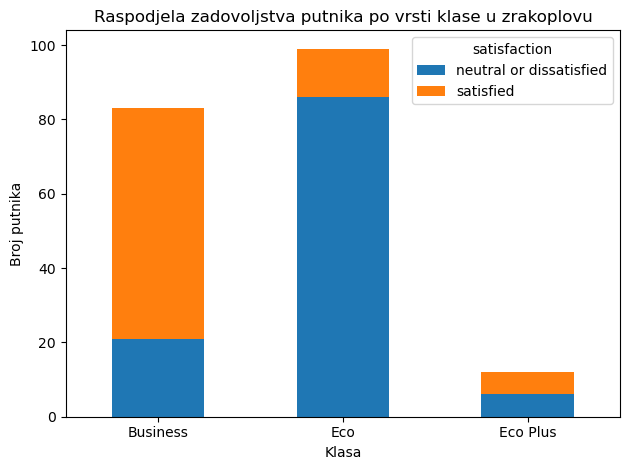

Ovaj graf prikazuje raspodjelu varijable zadovoljstva po klasama putovanja. Na x osi su klase putovanja, a na y osi je broj putnika. Narančasto označava dio ljudi koji su zadovoljeni, a plavo označava dio ljudi koji su neutralni ili nezadovoljni. Ovaj graf služi kako bi pokazao povezanost između zadovoljstva putnika ovisno o klasi putovanja. Vidimo kako najviše ljudi ima u eco klasi i velika večina njih je neutralna ili nezadovoljna. Najmanje ljudi je u eco plus klasi i tamo je pola ljudi zadovoljno, a pola nezadovoljno ili neutralno. 


In [19]:
#graf 1 priakzuje zadovoljstvo putnika na temelju klase

ct = pd.crosstab(data["Class"], data["satisfaction"])

plt.figure(figsize=(12, 7))
ct.plot(kind="bar", stacked=True)
plt.title("Raspodjela zadovoljstva putnika po vrsti klase u zrakoplovu")
plt.xlabel("Klasa")
plt.ylabel("Broj putnika")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(
    "Ovaj graf prikazuje raspodjelu varijable zadovoljstva po klasama putovanja. Na x osi su klase putovanja, a na y osi je broj putnika. Narančasto označava dio ljudi koji su zadovoljeni, a plavo označava dio ljudi koji su neutralni ili nezadovoljni. Ovaj graf služi kako bi pokazao povezanost između zadovoljstva putnika ovisno o klasi putovanja. Vidimo kako najviše ljudi ima u eco klasi i velika večina njih je neutralna ili nezadovoljna. Najmanje ljudi je u eco plus klasi i tamo je pola ljudi zadovoljno, a pola nezadovoljno ili neutralno. "
)

<Figure size 1200x700 with 0 Axes>

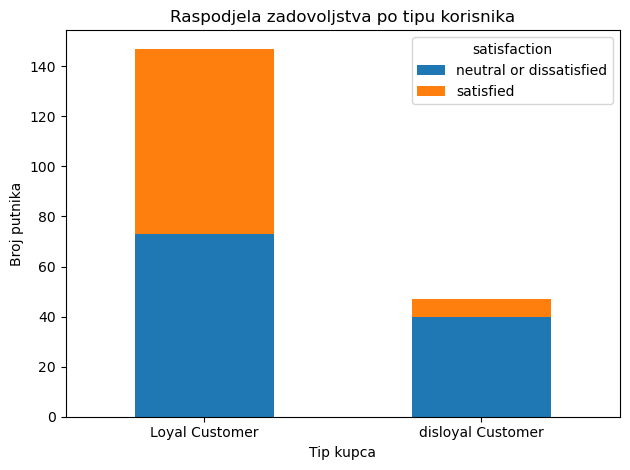

Ovaj graf prikazuje raspodjelu zadovoljstva putnika prema tipu korisnika. Na x osi imamo tip putnika/kupca karata, a na y osi imamo broj putnika. Ovaj graf nam pokazuje kako tip kupca/putnika utječe na samo zadovoljstvo kupca/putnika. Vidimo kako ima više lojalnih kupaca od nelojalnih, kod lojalnih vidimo da polovica njih je zadovoljna, a polovica nezadovoljna ili neutralna. Dok su nelojalni kupci većinom nezadovoljni ili neutralni. 


In [20]:
#graf 2 prikazuje zadovoljstvo putnika na temelju tipa korisnika, je li on vjeran kupac ili nevjeran

customer_ct = pd.crosstab(data["Customer_Type"], data["satisfaction"])

plt.figure(figsize=(12, 7))
customer_ct.plot(kind="bar", stacked=True)
plt.title("Raspodjela zadovoljstva po tipu korisnika")
plt.xlabel("Tip kupca")
plt.ylabel("Broj putnika")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(
    "Ovaj graf prikazuje raspodjelu zadovoljstva putnika prema tipu korisnika. Na x osi imamo tip putnika/kupca karata, a na y osi imamo broj putnika. Ovaj graf nam pokazuje kako tip kupca/putnika utječe na samo zadovoljstvo kupca/putnika. Vidimo kako ima više lojalnih kupaca od nelojalnih, kod lojalnih vidimo da polovica njih je zadovoljna, a polovica nezadovoljna ili neutralna. Dok su nelojalni kupci većinom nezadovoljni ili neutralni. "
)

<Figure size 1200x700 with 0 Axes>

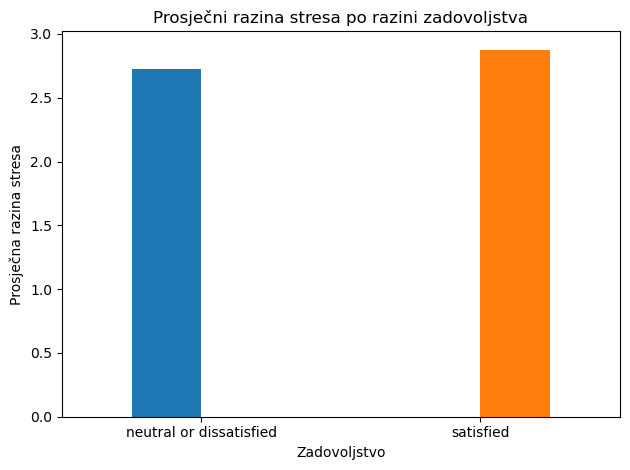

Ovaj graf prikazuje prosječnu razinu stresa ovisno o zadovoljstvu putnika. Na x osi imamo zadovoljstvo, a na y osi imamo prosječnu razinu stresa. Graf prikazuje kako razina stresa utječe na zadovoljstvo putnika. Vidimo kako putnici koji su zadovoljni putovanjem imaju veću prosječnu razinu stresa nasprem putnika koji su neutralni ili nezadovoljni. 


In [21]:
#graf 3 prikazuje kako razina stresa utječe na zadovoljstvo
stress_avg = pd.crosstab(data["satisfaction"], data["satisfaction"], 
                         values=data["stress_level"], aggfunc="mean")

plt.figure(figsize=(12, 7))
stress_avg.plot(kind="bar", legend=False)
plt.title("Prosječni razina stresa po razini zadovoljstva")
plt.xlabel("Zadovoljstvo")
plt.ylabel("Prosječna razina stresa")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(
    "Ovaj graf prikazuje prosječnu razinu stresa ovisno o zadovoljstvu putnika. Na x osi imamo zadovoljstvo, a na y osi imamo prosječnu razinu stresa. Graf prikazuje kako razina stresa utječe na zadovoljstvo putnika. Vidimo kako putnici koji su zadovoljni putovanjem imaju veću prosječnu razinu stresa nasprem putnika koji su neutralni ili nezadovoljni. "
)

Na kraju imamo prikaz rada same aplikacije, podaci se dohvaćaju iz tablice putnici uz pomoć REST API-a, u pregledniku upisujemo kao adresu http://127.0.0.1:8000/putnici/ 

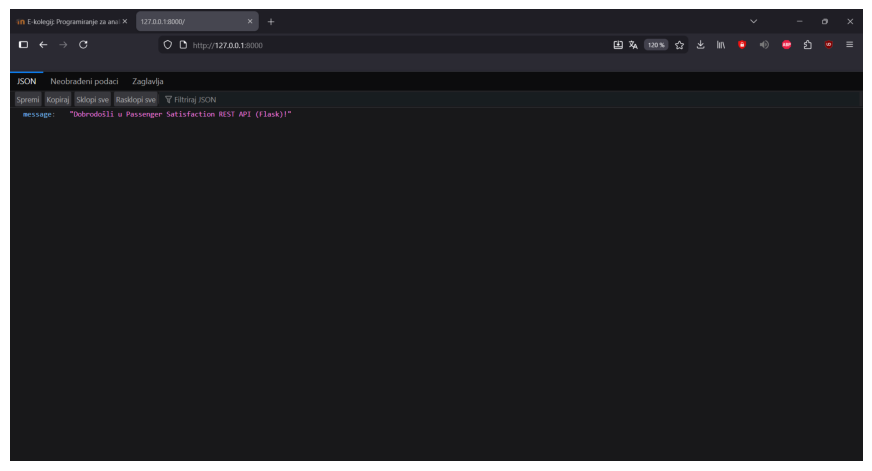

In [22]:
image_path = "slika 1.png"  
img = mpimg.imread(image_path)
plt.figure(figsize=(11, 11)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

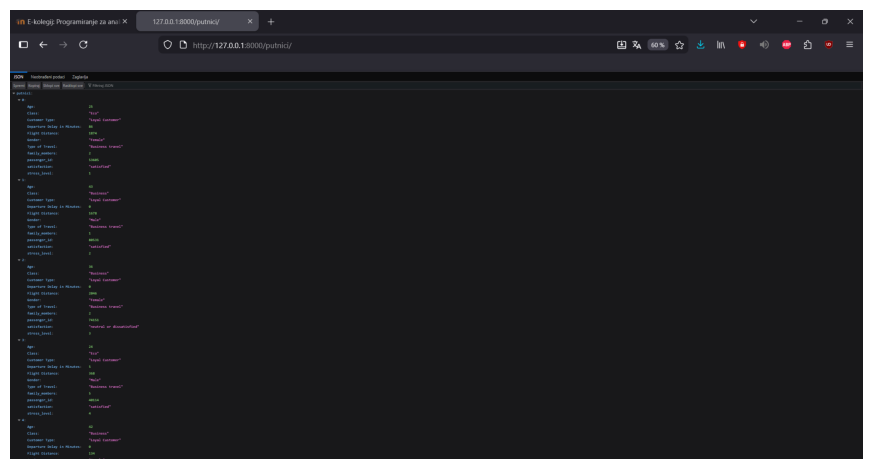

In [23]:
image_path = "slika 2.png"  
img = mpimg.imread(image_path)
plt.figure(figsize=(11, 11)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

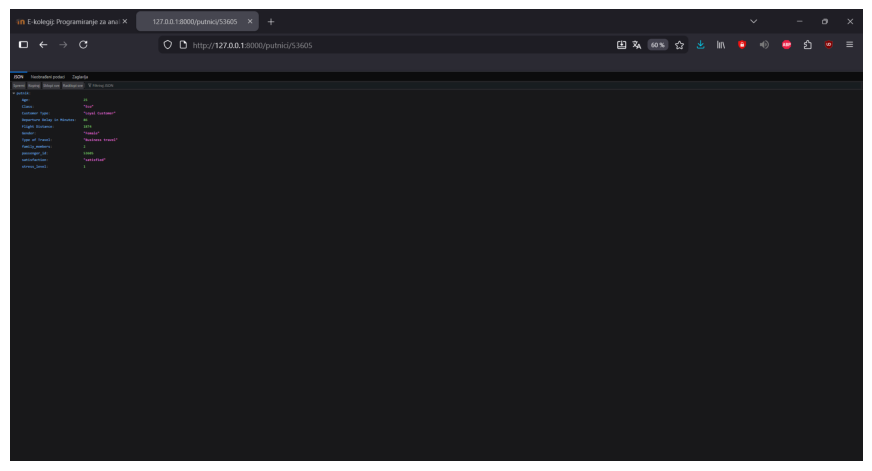

In [24]:
image_path = "slika 3.png"  
img = mpimg.imread(image_path)
plt.figure(figsize=(11, 11)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

<h1 style="font-size:32px;">Kritički osvrt</h1>

Praktična izvedivost i primjena ove aplikacija, kod koje se povezuje Flask s bazom podataka, omogućuje upravljanje i analizu podataka o zadovoljstu putnika. Aplikacija nije pre komplicirana za implementaciju te ju se može jednostavno proširiti, Flask je web framework koji nam omogućuje izradu API-a u pythonu, SQLite omogućuje lako postavljanje baze podataka te pruža brzu pohranu i dohvaćanje podataka. SQL upiti su korišteni za prisup samim podacima te za analizu. Pomoću Plotly je omogućena vizualizacija podataka, iz baze podataka, preko grafikona. Flask, SQLite i Plotly su zajedno dobra kombinacija alata za prikaz podataka u mome radu pošto nemam previše tih podataka, ali da se radi sa mnogo većim datasetom, sa mnogo više podataka, onda bi ova kombinacija bila malo ograničena, trebali bi se koristiti neki alati koji imaju više naprednijih funkcija te bolje i brže rade s ogromnim količinama podataka. Ovaj Flask se još uvijek koristi, ali pojavio se bolji i brži FastAPI koji se danas sve više i više počinje koristiti, on također nudi još malo ljepše sučelje za REST API jer uključuje swagger UI koji daje interaktivan prikaz za REST API. Ali za moj projekt je Flask sasvim u redu i dobro sve radi. Kod ove aplikacije bi se moglo još bolje optimizirati sama obrada podataka. Isto tako sami podaci u analizi nisu baš primjenjivi u stvarnom životu zbog toga što je dio podataka generiran preko generatedata.com, a u csv datoteci stupac zadovoljstvo ima samo dvije varijable, zadovoljan i neutralan ili nezadovoljan. Tako da se u csv datoteci trebalo u stupcu zadovoljstvo gledati tri varijable, zadovoljan, neutralan i nezadovoljan, time bi u grafovima mogli napraviti bolju i pregledniju analizu i zapravo imati podatke koji su donekle primjenjivi u stvarnom svijetu.

<h1 style="font-size:32px;">Zaključak</h1>

U ovom projektu je razvijena aplikacija koja omogućuje analizu podataka o zadovoljstvu putnika u zračnom prometu. Gleda se kako stress utječe na samo zadovoljstvo putnika u zračnom prometu, kako tip kupca te vrsta klase na zrakoplovu utječe na zadovoljstvo putnika u zračnom prometu. Flask nam omogućuje interakciju s bazom podataka preko API-a, a grafovi služe za vizualizaciju podataka te da korisnici bolje razumiju što i koliko utječe na zadovoljstvo putnika u zračnom prometu. Projekt priakzuje osnovne principe rada s bazom podataka i vizualizaciju samih podataka, no sami podaci se ne bi trebali koristiti kao primjer za stvarni život. Zato što su podaci u json datoteci nasumično generirani, a csv stupac zadovoljstvo ima samo dvije varijable, zadovoljan i neutralan ili nezadovoljan. Dalje bi trebalo u csv samo promijeniti stupac zadovoljstvo tako da ima tri varijable, zadovoljan, neutralan, nezadovoljan time bi sama analiza podataka bila detaljnija i korisnija. Isto tako trebao bi se povećati broj osoba unutar csv-a jer bi time dobili realističnije rezultate i bolju analizu, bilo bi dobro da se radi na večem uzorku.

<h1 style="font-size:32px;">Literatura</h1>

[1] Flask: Flask is a lightweight WSGI web application framework. Na: https://flask.palletsprojects.com/en/stable/ , Pristup: Siječanj 2026.

[2] "SQLAlchemy Documentation," SQLAlchemy. Na: https://www.sqlalchemy.org/ , Pristup: Siječanj 2026.

[3] Plotly, Interactive Graphing and Data Visualization. Na: https://plotly.com/ , Pristup: Siječanj 2026.

[4] Python Software Foundation, "SQLite3 module documentation. Na: https://docs.python.org/3/library/sqlite3.html , Pristup: Siječanj 2026.

[5] OpenAI, ChatGPT: Prompt razgovora s CHAT-GPT-om: https://chatgpt.com/share/696f909d-12c4-8005-9948-bb4e4b7dc6c0 , Pristup: Siječanj 2026.